# Sensitivity analysis 
using OGGM edu glacier model
by Thomas Gölles, 2024

In [54]:
from oggm_edu import GlacierBed, Glacier, MassBalance, GlacierCollection
import SALib as salib
import numpy as np

from matplotlib import pyplot as plt

## General OGGM definitions

In [7]:
# Lets define the bed.
# Top and bottom altitude.
top = 5000
bottom = 0
# How far does the accumulation area extend?
accumulation_fraction = 1 / 3
# ELA altitude
ela_alt = (top - bottom) * (1 - accumulation_fraction)
# Accumulation area starts out as 1000 m. wide.
top_width = 1000
# 500 m. wide after ELA.
ela_width = 500

# Bed, note that we increase the map_dx here,
# we increase the grid point spacing.
bed = GlacierBed(
    altitudes=[top, ela_alt, bottom],
    widths=[top_width, ela_width, ela_width],
    map_dx=200,
)

Lets investigate how the mass blance influences the volume

In [8]:
mb_gradient = 7
mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)

In [47]:
mass_balance.ela

3333.3333333333335

In [9]:
glacier = Glacier(bed, mass_balance=mass_balance)
glacier.progress_to_equilibrium()

In [10]:
glacier

,
Attribute,
Id,1
Type,Glacier
Age,127
Length [m],35600.0
Area [km2],21.15
Volume [km3],6.282884
Max ice thickness [m],342.297831
Max ice velocity [m/yr],902.8394591929571
AAR [%],53.664303


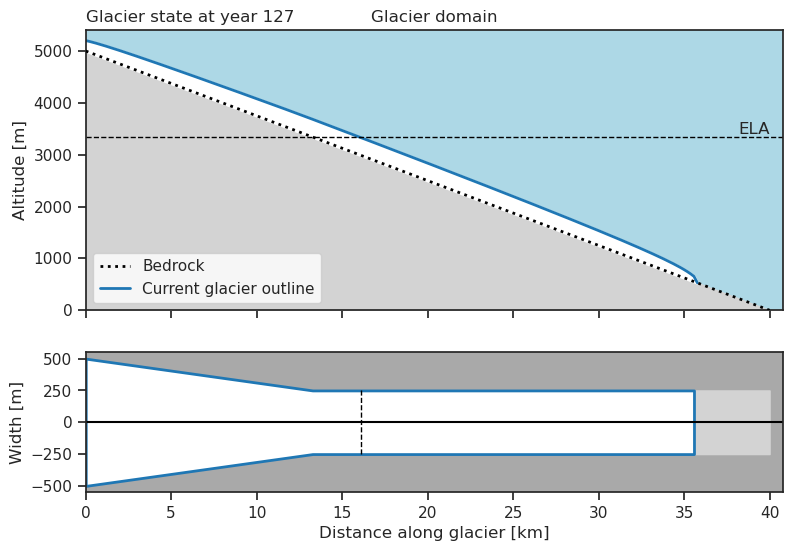

In [12]:
glacier.plot()

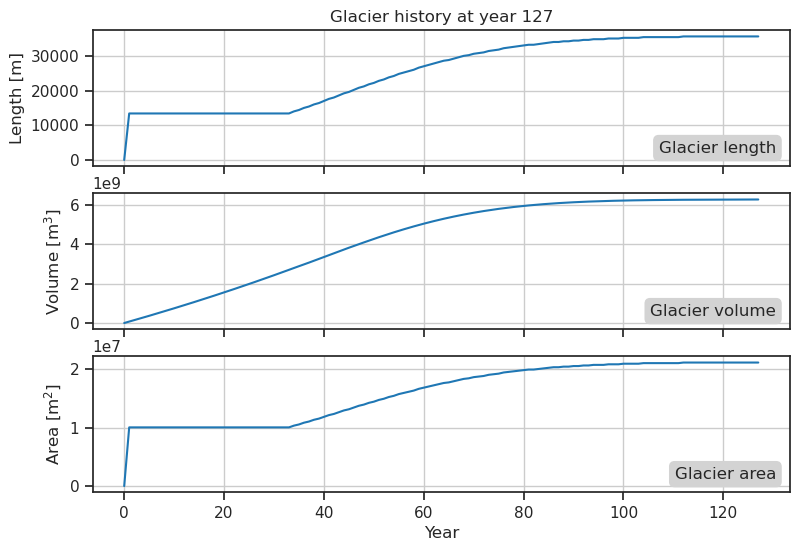

In [15]:
glacier.plot_history()

In [48]:
glacier.history

<xarray.Dataset>
Dimensions:           (time: 2501)
Coordinates:
  * time              (time) float64 0.0 1.0 2.0 ... 2.498e+03 2.499e+03 2.5e+03
    calendar_year     (time) int64 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499 2500
    calendar_month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    hydro_year        (time) int64 0 1 2 3 4 5 ... 2495 2496 2497 2498 2499 2500
    hydro_month       (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4
Data variables:
    volume_m3         (time) float64 0.0 5.872e+05 ... 1.549e+09 1.55e+09
    volume_bsl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    volume_bwl_m3     (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    area_m2           (time) float64 0.0 1.005e+07 ... 1.425e+07 1.425e+07
    length_m          (time) float64 0.0 1.34e+04 1.34e+04 ... 2.18e+04 2.18e+04
    calving_m3        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    calving_rate_myr  (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/13)
    description:          OGGM model output
    oggm_version:         1.6.1
    calendar:             365-day no leap
    creation_date:        2024-02-12 06:32:01
    water_level:          0
    glen_a:               2.4e-24
    ...                   ...
    mb_model_class:       MassBalance
    mb_model_hemisphere:  nh
    mb_model_rho:         900.0
    mb_model_orig_ela_h:  3333.3333333333335
    mb_model_ela_h:       3333.3333333333335
    mb_model_grad:        0.05690780716354519

## OAT sensitivity analysis

We interessed in the equilibirum glacier volume. And we want to know how the glacier reacts to massbalance gadients form 0.01 to 10.

For we need a function which takes the mb_graident and gives us the resulting glacier in quilibrium. Then we varay the massbalance gradient and analyse the outcome.

In [30]:
def evaluate_model(mb_gradient):
    mass_balance = MassBalance(ela=ela_alt, gradient=mb_gradient)
    glacier = Glacier(bed, mass_balance=mass_balance)
    glacier.progress_to_equilibrium()
    return glacier

In [35]:
mb_gradient_min = 0.01
mb_gradient_max = 10
number_of_samples = 100
np.random.seed(0)  # so the results are reproducible and everyone gets the same results
mb_gradient_samples = np.random.uniform(
    mb_gradient_min, mb_gradient_max, number_of_samples
)
mb_gradient_samples

array([5.4926469 , 7.15474177, 6.03160613, 5.453383  , 4.24231145,
       6.46248219, 4.38149624, 8.91881228, 9.63699098, 3.84058077,
       7.91933313, 5.29366025, 5.68476517, 9.25671042, 0.71965022,
       0.8804217 , 0.21198179, 8.32787226, 7.78378594, 8.70142136,
       9.78639724, 7.99359406, 4.62017883, 7.80748647, 1.19156151,
       6.402811  , 1.44209934, 9.44724248, 5.22326473, 4.15247278,
       2.65291056, 7.74459456, 4.56694182, 5.68865515, 0.19771011,
       6.18017862, 6.12483627, 6.17317063, 9.4380433 , 6.82138479,
       3.60148393, 4.37594922, 6.97933565, 0.61165246, 6.67099949,
       6.70967232, 2.11172179, 1.29797371, 3.16112923, 3.6434706 ,
       5.70626574, 4.39162912, 9.88385464, 1.02942766, 2.09667879,
       1.62148208, 6.53455217, 2.54038311, 4.66844462, 2.45181166,
       1.59810614, 1.11264766, 6.5667326 , 1.39044768, 1.97385779,
       3.69356445, 8.21172237, 0.98004175, 8.38106963, 0.97002309,
       9.76483006, 4.6918255 , 9.76784327, 6.05240674, 7.39524

Ok, now we have the sample for our one one at the time sensitivity analysis.

Now lets generate a list with all the glaciers for the different mass balance gradients. We need an empty list to which we append the results run in a for loop:

In [36]:
results = []
for mb_gradient in mb_gradient_samples:
    glacier = evaluate_model(mb_gradient)
    results.append(glacier)
    print(f"Done with mb_gradient: {mb_gradient}")

Done with mb_gradient: 5.4926469042339745
Done with mb_gradient: 7.15474177006047
Done with mb_gradient: 6.031606126955722
Done with mb_gradient: 5.453382998138999
Done with mb_gradient: 4.242311445395658
Done with mb_gradient: 6.462482189535894
Done with mb_gradient: 4.381496240514298
Done with mb_gradient: 8.918812277812977
Done with mb_gradient: 9.636990977405283
Done with mb_gradient: 3.840580773069519
Done with mb_gradient: 7.919333130445819
Done with mb_gradient: 5.293660248331515
Done with mb_gradient: 5.6847651653283835
Done with mb_gradient: 9.256710416543683
Done with mb_gradient: 0.7196502213968906
Done with mb_gradient: 0.8804217040183917
Done with mb_gradient: 0.21198179042885396
Done with mb_gradient: 8.3278722570239
Done with mb_gradient: 7.783785941989006
Done with mb_gradient: 8.701421360985723
Done with mb_gradient: 9.786397238905312
Done with mb_gradient: 7.993594056525069
Done with mb_gradient: 4.620178828906789
Done with mb_gradient: 7.80748647110169
Done with mb_g

Now OGGM_edu has a usefull class called GlacierCollection

In [40]:
ota_runs = GlacierCollection(results)

Now lets plot the equilibrium volume vs the mass balance gradient:

Text(0, 0.5, 'Volume [km3]')

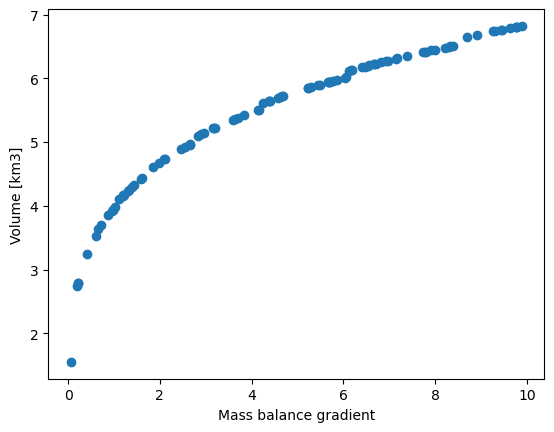

In [46]:
plt.scatter(mb_gradient_samples, ota_runs.summary()["Volume [km3]"])
plt.xlabel("Mass balance gradient")
plt.ylabel("Volume [km3]")

What do we see here?

* The volume depends on the mass balance gradient
* it is non-linear
* it looks exponential
* where there is a lot of change at low mass balance gradients we have rader few points

What are soem real world implications*

* Glaciers with low mass balance gradient are more sensitive to climate

Limitations of OAT:

* no interactions between multiple factors 
* in reality multiply factors change at teh same time

OAT is usefull for inital insights but to capture feedbacks more advanced sensitivity analysis methods are needed.

## Using SALib and the Sobol method with one varible

Lets repeat the same experiment but using SALib.
First we need to defien the "priboblem", i.e, the epxeriment 
Again vary the mb gradient form 0.01 to 10

In [62]:
problem = {"num_vars": 1, "names": ["mb_gradient"], "bounds": [[0.01, 10]]}

Instead of choosing randomly we use the Sobol sampler

In [63]:
number_of_samples = 50

Now lets generate the samples. i.e. the list of inputs to test the model with

In [64]:
param_values = salib.sample.sobol.sample(problem, number_of_samples)

/opt/conda/lib/python3.11/site-packages/scipy/stats/_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [65]:
param_values

array([[2.62001629],
       [8.1358466 ],
       [2.62001629],
       [8.1358466 ],
       [7.57418264],
       [0.69226208],
       [7.57418264],
       [0.69226208],
       [6.61162281],
       [6.46769873],
       [6.61162281],
       [6.46769873],
       [1.65379794],
       [3.9213261 ],
       [1.65379794],
       [3.9213261 ],
       [0.96123263],
       [5.82494988],
       [0.96123263],
       [5.82494988],
       [6.07145469],
       [3.29809015],
       [6.07145469],
       [3.29809015],
       [9.51854323],
       [8.76136071],
       [9.51854323],
       [8.76136071],
       [4.40466279],
       [1.29826334],
       [4.40466279],
       [1.29826334],
       [4.01217318],
       [7.48611851],
       [4.01217318],
       [7.48611851],
       [8.97483789],
       [4.95956335],
       [8.97483789],
       [4.95956335],
       [5.52317145],
       [7.92533391],
       [5.52317145],
       [7.92533391],
       [0.57392113],
       [0.46193196],
       [0.57392113],
       [0.461

we reuse the function "elevate_model" from above. Which takes the mb_gradient as input and runs the glacier to equilibrium.
We need to adjust the for loop a bit since, the param_values with our sampel is a list of lists. (therfore the forcing[0])



In [66]:
results = []
for forcing in param_values:
    mb_gradient = forcing[0]
    glacier = evaluate_model(forcing)
    results.append(glacier)
    print(f"Done with mb_gradient: {mb_gradient}")

Done with mb_gradient: 2.6200162892229852
Done with mb_gradient: 8.135846604676917
Done with mb_gradient: 2.6200162892229852
Done with mb_gradient: 8.135846604676917
Done with mb_gradient: 7.574182635983452
Done with mb_gradient: 0.6922620829194784
Done with mb_gradient: 7.574182635983452
Done with mb_gradient: 0.6922620829194784
Done with mb_gradient: 6.611622808678075
Done with mb_gradient: 6.46769872511737
Done with mb_gradient: 6.611622808678075
Done with mb_gradient: 6.46769872511737
Done with mb_gradient: 1.653797940220684
Done with mb_gradient: 3.921326100695878
Done with mb_gradient: 1.653797940220684
Done with mb_gradient: 3.921326100695878
Done with mb_gradient: 0.9612326301448048
Done with mb_gradient: 5.824949884172529
Done with mb_gradient: 0.9612326301448048
Done with mb_gradient: 5.824949884172529
Done with mb_gradient: 6.071454692510888
Done with mb_gradient: 3.2980901507940144
Done with mb_gradient: 6.071454692510888
Done with mb_gradient: 3.2980901507940144
Done with 

In [67]:
sobol_runs = GlacierCollection(results)

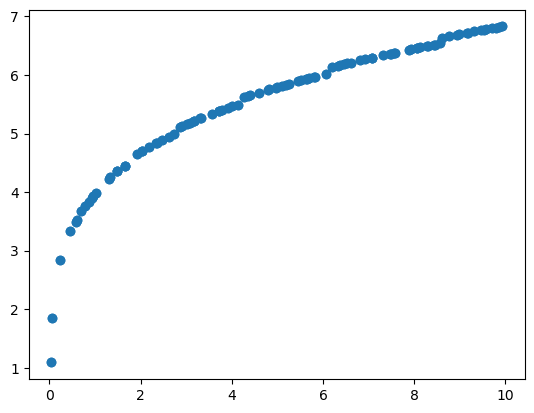

In [68]:
# scatter plot of param_values vs. all_runs.summary()["Volume [km3]"]
plt.scatter(param_values, sobol_runs.summary()["Volume [km3]"])

What to we see here?

* more evently spaced samples
* the same conclustions as with the somple OAT approach.

Now we can actually analyse the Sobol Sensitivity measures:

In [73]:
sobol_result = salib.analyze.sobol.analyze(
    problem, sobol_runs.summary()["Volume [km3]"].values
)

In [72]:
sobol_result

{'S1': array([1.07101752]),
 'S1_conf': array([0.43326985]),
 'ST': array([1.03118786]),
 'ST_conf': array([0.26768566]),
 'S2': array([[nan]]),
 'S2_conf': array([[nan]])}

What do the values mean?

* S1 is the first-order sensitivity index and should be between 0 and 1
* S1 is larger than 1 => might need more samples. In this case it should be 1 since all the Variance of the output is form one input (the mass balance gradient)
* S1_conf quite large so significant uncertainties about the S1

* ST the Total Sensitivity Index sould also be 1 and the same is S1 since ther are not interactions with other variables

* S2 has a  not a number value (nan), since we only had one paramter.

So sobol sensitivity for one varialbe gives not much more insight then OTA, but now lets try it for multiple inputs
